In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lti
from numpy.linalg import matrix_power
import cvxopt
import snakeviz
%load_ext snakeviz

# Problem A: Cruise control

equation of the system:

$m \, a(t) = m \, \dot v(t) = - b \, v(t) + F(t) - d(t)$ 

$\dot v(t) = -\frac{b}{m} \, v(t) + \frac{1}{m} \, F(t) -\frac{1}{m} \, d(t)$

![image.png](problemAgraphic.png)

In [2]:
class CarSystem():
    def __init__(self, start_position=0, start_velocity=0, mass_kg=1000, friction_coeff=10, slope_degr=5, sample_time=1):
        self.mass_kg = mass_kg
        self.friction_coeff = friction_coeff
        self.slope_rad = slope_degr*np.pi/180
        self.sample_time = sample_time
        disturbance = 9.81*np.sin(self.slope_rad)

        self.state = np.vstack([start_velocity,start_position,disturbance])

        self.A = np.array([[-friction_coeff/mass_kg, 0., -1], [1., 0., 0.], [0., 0., 0.]])
        self.B = np.array([[1/mass_kg,],[0.],[0.]])
        self.C = np.array([[1., 0., 0.],[0., 1., 0.]])
        self.D = np.array([[0.],[0.]])

        self.discrete_system = lti(self.A, self.B, self.C, self.D).to_discrete(sample_time)
        self.state_log = [self.state]    

    @property
    def state_dim(self):
        return self.discrete_system.A.shape[1]
    
    @property
    def input_dim(self):
        return self.discrete_system.B.shape[1]

    @property
    def output_dim(self):
        return self.discrete_system.C.shape[0]

    @property
    def position(self):
        return self.state[1][0]
    
    @property
    def velocity(self):
        return self.state[0][0]

    @property
    def log(self):
        velocity_log, position_log, disturbance_log = np.hstack(self.state_log)
        return position_log, velocity_log, disturbance_log

    @property
    def output(self):
        return self.discrete_system.C @ self.state
    
    def step(self, control):
        self.state = self.discrete_system.A@self.state + self.discrete_system.B@control
        self.state_log.append(self.state)

In [3]:
class KalmanFilter():
    def __init__(self, A, C, state_noise_cov=None, output_noise_cov=None, initial_state=None, P=None):
        self.A, self.C = A, C
        self.output_dim, self.state_dim = C.shape

        self.P = P if P is not None else np.identity(self.state_dim)
        self.state_estimate = initial_state if initial_state is not None else np.vstack([0. for _ in range(self.state_dim)])
        self.log = [self.state_estimate]

        self.Q = state_noise_cov if state_noise_cov is not None else np.identity(self.state_dim)
        self.R = output_noise_cov if output_noise_cov is not None else np.identity(self.output_dim)

        self.is_steady = False

        if P is None:
            while not self.is_steady:
                self.update_confidence()            

    def update_confidence(self):
        if self.is_steady: 
            return
        new_P = self.A@(self.P - self.P@self.C.T@np.linalg.inv(self.C@self.P@self.C.T + self.R)@self.C@self.P)@self.A.T + self.Q
        self.is_steady = not np.any(np.abs(new_P - self.P) > 1e-08)
        self.P = new_P

    def update_estimate(self, imposed_state_deviation, system_output):
        expected_new_state = self.A@self.state_estimate + imposed_state_deviation
        self.state_estimate = expected_new_state + self.observer_gain@(system_output-self.C@self.state_estimate)
        self.update_confidence()
        self.log.append(self.state_estimate)

    @property
    def observer_gain(self):
        L = self.A @ self.P @ self.C.T @ np.linalg.inv(self.C @ self.P @ self.C.T + self.R)
        return L


class MPCController():
    def __init__(self, system, horizon, q=1, r=0, gamma=1, Xmin=None, Xmax=None, Umin=None, Umax=None, Ymin=None, Ymax=None):
        self.control_action_log = []
        self.system, self.horizon, self.q, self.r, self.gamma = system, horizon, q, r, gamma
        self.state_observer = KalmanFilter(A=self.system.discrete_system.A, C=self.system.discrete_system.C, state_noise_cov=np.diag([0.001,0.0,0.0]), output_noise_cov=np.diag([0.0,0.0]))

        self.A_cal, self.B_cal, self.C_cal, self.Q_cal, self.R_cal = self.get_condensed_matrices()
        self.W, self.S, self.G = self.get_constraints_matrices(Xmin, Xmax, Umin, Umax, Ymin, Ymax)

    @property
    def log(self):
        estimated_velocity_log, estimated_position_log, estimated_disturbance_log = np.hstack(self.state_observer.log)
        return np.hstack(self.control_action_log), estimated_position_log, estimated_velocity_log, estimated_disturbance_log

    def get_constraints_matrices(self, Xmin, Xmax, Umin, Umax, Ymin, Ymax):
        W, S, G = [], [], []
        
        if Xmin is not None:
            W.append(np.vstack([-c for c in Xmin for _ in range(self.horizon)]))
            S.extend(self.A_cal)
            G.extend(-self.B_cal)
        
        if Xmax is not None:
            W.append(np.vstack([c for c in Xmax for _ in range(self.horizon)]))
            S.extend(-self.A_cal)
            G.extend(self.B_cal)

        if Umin is not None:
            W.append(np.vstack([-c for c in Umin for _ in range(self.horizon)]))
            S.extend(np.zeros((self.B_cal.shape[1],self.A_cal.shape[1])))
            G.extend(-np.identity(self.B_cal.shape[1]))

        if Umax is not None:
            W.append(np.vstack([c for c in Umax for _ in range(self.horizon)]))
            S.extend(np.zeros((self.B_cal.shape[1],self.A_cal.shape[1])))
            G.extend(np.identity(self.B_cal.shape[1]))

        if Ymin is not None:
            W.append(np.vstack([-c for c in Ymin for _ in range(self.horizon)]))
            S.extend(self.C_cal@self.A_cal,)
            G.extend(-self.C_cal@self.B_cal)

        if Ymax is not None:
            W.append(np.vstack([c for c in Ymax for _ in range(self.horizon)]))
            S.extend(-self.C_cal@self.A_cal,)
            G.extend(self.C_cal@self.B_cal)

        return np.vstack(W), np.vstack(S), np.vstack(G)

    def get_condensed_matrices(self, n=None):
        if n is None: 
            n = self.horizon
        A, B, C = self.system.discrete_system.A, self.system.discrete_system.B, self.system.discrete_system.C
        Q, R = self.q*np.identity(self.system.output_dim), self.r*np.identity(self.system.input_dim)

        if n == 1:
            return A, B, C, Q, R

        A_cal, B_cal, C_cal, Q_cal, R_cal = self.get_condensed_matrices(n-1)

        A_cal = np.block([[A, ], [A_cal @ A]])
        B_cal = np.block(
            [[B_cal, np.zeros((B_cal.shape[0], B.shape[1]))],
             [A @ B_cal[-B.shape[0]:, :], B]]
        )
        C_cal = np.block(
            [[C, np.zeros((C.shape[0], C_cal.shape[1]))],
             [np.zeros((C_cal.shape[0], C.shape[1])), C_cal*self.gamma]]
        )
        Q_cal = np.block(
            [[Q, np.zeros((Q.shape[0], Q_cal.shape[1]))],
             [np.zeros((Q_cal.shape[0], Q.shape[1])), Q_cal*self.gamma]]
        )
        R_cal = np.block(
            [[R, np.zeros((R.shape[0], R_cal.shape[1]))],
             [np.zeros((R_cal.shape[0], R.shape[1])), R_cal*self.gamma]]
        )

        return A_cal, B_cal, C_cal, Q_cal, R_cal

    def get_qp_params(self, target_signal):
        P = cvxopt.matrix(2 * (self.B_cal.T @ self.C_cal.T @ self.Q_cal @ self.C_cal @ self.B_cal + self.R_cal))
        q_t = cvxopt.matrix(2 * (self.C_cal @ self.A_cal @ self.state_observer.state_estimate - target_signal).T @ self.Q_cal @ self.C_cal @ self.B_cal)
        G = cvxopt.matrix(self.G)
        h = cvxopt.matrix(self.W+self.S@self.system.state)
        return {"P":P, "q":q_t.T, "G":G, "h":h}

    def compute_control(self, target_output):
        target_signal = np.vstack([target_output for _ in range(self.horizon)])
        cvxopt.solvers.options["show_progress"] = False
        solution = cvxopt.solvers.qp(**self.get_qp_params(target_signal))
        return np.array(solution["x"])[:1,:]

    def step(self, target_output):
        control_action = self.compute_control(target_output)
        self.control_action_log.append(control_action)
        self.system.step(control_action)
        self.state_observer.update_estimate(imposed_state_deviation=self.system.discrete_system.B@control_action, system_output=self.system.output)
        


In [4]:
#%%snakeviz --new-tab
horizon = 100
system = CarSystem(start_position=0., start_velocity=0., slope_degr=0.)
controller = MPCController(system, horizon, r=0.001, Umin=(-10000,), Umax=(10000,))

A_cal, B_cal, C_cal, Q_cal, R_cal = controller.get_condensed_matrices()

target_position = 10
target_velocity = 0
target_ouput = np.vstack((target_velocity, target_position))

times = np.arange(0,100+1)

for t in times[1:]:
    controller.step(target_ouput)

Text(0.5, 0, 't(s)')

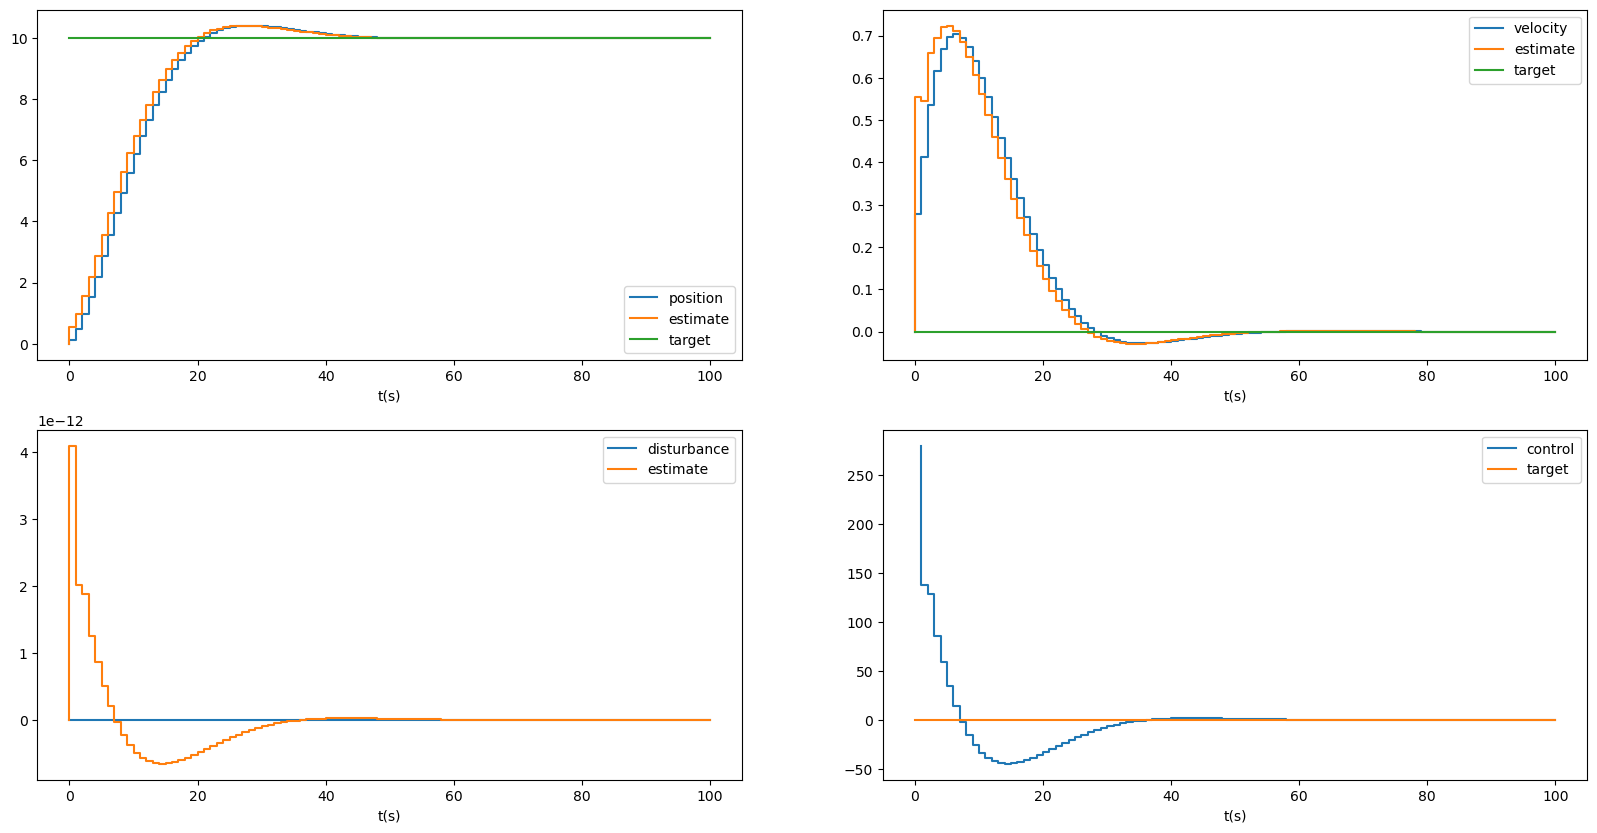

In [5]:
position_log, velocity_log, disturbance_log = system.log

(control_log,), estimated_position_log, estimated_velocity_log, estimated_disturbance_log = controller.log

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.step(times, position_log, label="position")
plt.step(times, estimated_position_log, label="estimate")
plt.plot([target_position for t in times], label="target")
plt.legend()
plt.xlabel("t(s)")

plt.subplot(222)
plt.step(times, velocity_log, label="velocity")
plt.step(times, estimated_velocity_log, label="estimate")
plt.plot([target_velocity for t in times], label="target")
plt.legend()
plt.xlabel("t(s)")

plt.subplot(223)
plt.step(times, disturbance_log, label="disturbance")
plt.step(times, estimated_disturbance_log, label="estimate")
plt.legend()
plt.xlabel("t(s)")

plt.subplot(224)
plt.step(times[1:], control_log, label="control")
plt.plot([0 for t in times], label="target")
plt.legend()
plt.xlabel("t(s)")